# Analysis of Global UHI Data
By Josh Houlding

Urban Heat Islands (UHIs) are a phenomenon in which the surface and air temperatures of urban areas are higher than those of surrounding suburban and rural areas due to factors like increased prevalence of manmade materials, higher energy use, and industrial activity. Dense and highly developed cities such as New York City, Phoenix, Tokyo, and Delhi are especially vulnerable to UHIs. They can be mitigated by increasing green space coverage within cities and installing infrastructure such as cool roofs. This project aims to predict and model UHIs in cities worldwide using publicly available datasets, uncovering trends and patterns that can inform sustainable urban planning and public health policy, as well as guide mitigation strategies like increasing green space and implementing cool roof technologies.

This notebook contains an analysis of a dataset acquired from NASA's [SEDAC (Socioeconomic Data and Applications Center)](https://earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-sdei-uhi2013-1.00) containing data on land area, population, day-night temperature differences, and so on for tens of thousands of cities worldwide. This data provides the opportunity to uncover links between a city's demographic and geographic characteristics and its UHI intensities, highlighting the most important factors in UHI formation.

<b>Central analysis question:</b> What are the most important factors driving the formation of UHIs?

# Loading and Cleaning the Data

In [1]:
import pandas as pd

In [2]:
# Load data
df = pd.read_excel("sdei-global-uhi-2013/sdei-global-uhi-2013.xlsx", sheet_name="sdei_global_uhi_2013")

C:\Users\jdh10\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
# View data
print(f"Data shape: {df.shape}")
df.head()

Data shape: (31500, 17)


ISOURBID ISO3  URBID         NAME        SCHNM  ES90POP  ES95POP  ES00POP  \
0     GRL8  GRL      8    Upernavik    UPERNAVIK      918   1015.0     1123   
1    USA15  USA     15       Barrow       BARROW     3469   3986.0     4581   
2    NOR17  NOR     17  Honningsvåg  HONNINGSVAG     2237   2356.0     2510   
3    NOR19  NOR     19    Hav?ysund    HAVOYSUND     1285   1235.0     1163   
4    NOR21  NOR     21  Kj?llefjord  KJOLLEFJORD     1159   1115.0     1049   

   SQKM_FINAL  URB_D_MEAN  BUF_D_MEAN  D_T_DIFF  URB_N_MEAN  BUF_N_MEAN  \
0    4.930040    7.045000    7.949783 -0.904783   -3.160769   -1.656825   
1  152.207993   10.649261   12.410973 -1.761712   -0.450627    0.797396   
2   47.580002   16.663023   14.530072  2.132951    5.432439    6.723416   
3   19.442101   14.613750   14.874419 -0.260669    5.606563    5.751090   
4   35.155300   20.332540   18.241400  2.091139    4.567778    6.963166   

   N_T_DIFF   LATITUDE   LONGITUDE  
0 -1.503944  72.788598  -56.140056  
1 -1.248022  71.303963 -156.730206  
2 -1.290977  71.004989   25.962568  
3 -0.144527  70.983068   24.652803  
4 -2.395389  70.943870   27.356392

### Variable details

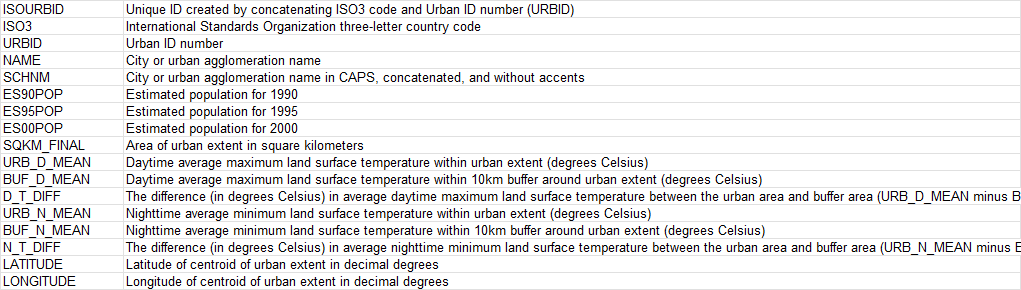

This is a large dataset, so for the sake of pipeline and model performance, we will filter it down to cities with over 100,000 residents. This has the added benefit of limiting the analysis to cities that are likely to have significant UHI effects, have higher-quality data available, and are more relevant to policymakers, urban planners and environmentalists.

In [4]:
# Filter dataset down to cities with at least 100k residents
df = df[df["ES00POP"] >= 100000]

# Show new dataset shape
print(f"Dataset shape: {df.shape}")

Dataset shape: (3519, 17)


### Dropping unnecessary columns

We will simply use the agglomeration name, `SCHNM`, instead of `NAME` because it is free of special characters. The 1990 and 1995 population estimates are also not necessary because no time series analysis is possible with this data.

In [5]:
# Drop columns
df.drop(columns={"NAME", "ES90POP", "ES95POP"}, inplace=True)

### Renaming columns
Column names in all lowercase with underscores separating words are easier to read and type out than the default all-caps names we find in this dataset by default.

In [6]:
# Create new column mapping
new_column_mapping = {"ISOURBID": "isourbid", "ISO3": "iso3", "URBID": "urbid", "SCHNM": "name", "ES00POP": "pop_2000", 
                      "SQKM_FINAL": "area_sq_km", "URB_D_MEAN": "urban_day_mean", "BUF_D_MEAN": "buffer_day_mean", 
                      "D_T_DIFF": "day_diff", "URB_N_MEAN": "urban_night_mean", "BUF_N_MEAN": "buffer_night_mean", 
                      "N_T_DIFF": "night_diff", "LATITUDE": "latitude", "LONGITUDE": "longitude"}

# Apply new column mapping
df.rename(columns=new_column_mapping, inplace=True)

In [7]:
# Show new column names
print(df.columns)
df.head(1)

Index(['isourbid', 'iso3', 'urbid', 'name', 'pop_2000', 'area_sq_km',
       'urban_day_mean', 'buffer_day_mean', 'day_diff', 'urban_night_mean',
       'buffer_night_mean', 'night_diff', 'latitude', 'longitude'],
      dtype='object')


isourbid iso3  urbid      name  pop_2000  area_sq_km  urban_day_mean  \
22    NZL96  NZL     96  HASTINGS    113497  346.338989        32.95503   

    buffer_day_mean  day_diff  urban_night_mean  buffer_night_mean  \
22        30.811864  2.143166         12.152994          12.060181   

    night_diff   latitude   longitude  
22    0.092813 -39.507647  176.861014

### Feature engineering

In [8]:
# Create column for population per square kilometer
df["pop_per_sq_km"] = df["pop_2000"] / df["area_sq_km"]

### Checking data types
We must ensure that all text variables are in object format, and all numeric variables are in some form of int or float format.

In [9]:
# View data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3519 entries, 22 to 31434
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isourbid           3519 non-null   object 
 1   iso3               3519 non-null   object 
 2   urbid              3519 non-null   int64  
 3   name               3519 non-null   object 
 4   pop_2000           3519 non-null   int64  
 5   area_sq_km         3519 non-null   float64
 6   urban_day_mean     3519 non-null   float64
 7   buffer_day_mean    3519 non-null   float64
 8   day_diff           3519 non-null   float64
 9   urban_night_mean   3512 non-null   float64
 10  buffer_night_mean  3518 non-null   float64
 11  night_diff         3512 non-null   float64
 12  latitude           3519 non-null   float64
 13  longitude          3519 non-null   float64
 14  pop_per_sq_km      3519 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 439.9+ KB


All data types are appropriate.

### Handling duplicates
Duplicate entries need to be removed from this dataset because each city in the dataset only requires a single entry, and thus every duplicate is necessarily an error.

In [10]:
# Drop duplicates
print(f"Original entry count: {len(df)}")
df = df.drop_duplicates()
print(f"Entry count after dropping duplicates: {len(df)}")

Original entry count: 3519
Entry count after dropping duplicates: 3519


No duplicates were present in this data, but it's always worthwhile to check in cases like this.

### Handling missing values
Missing values must be dealt with to improve data quality and thus improve the model's effectiveness.

In [11]:
# Show missing value count per column
print(f"Rows with missing values: {df.isna().sum().sum()} \n")
print(f"Missing value count by column: \n {df.isna().sum()}")

Rows with missing values: 15 

Missing value count by column: 
 isourbid             0
iso3                 0
urbid                0
name                 0
pop_2000             0
area_sq_km           0
urban_day_mean       0
buffer_day_mean      0
day_diff             0
urban_night_mean     7
buffer_night_mean    1
night_diff           7
latitude             0
longitude            0
pop_per_sq_km        0
dtype: int64


I originally tried filling the missing `urban_day_mean`, `urban_night_mean` and `buffer_night_mean` values with the mean of each column, but I encountered data quality issues later on, so I decided to use KNN imputation instead. Then, we will recalculate `day_diff` and `night_diff`, as these columns depend on the aforementioned mean columns.

In [12]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Select columns to standardize and impute
cols_to_impute = ["urban_day_mean", "urban_night_mean", "buffer_night_mean"]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols_to_impute])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5, weights="uniform")  # Or weights="distance"
df_imputed = imputer.fit_transform(df_scaled)

# Reverse scaling to original scale
df[cols_to_impute] = scaler.inverse_transform(df_imputed)

# Impute missing values with the mean
df["urban_day_mean"].fillna(df["urban_day_mean"].mean(), inplace=True)
df["urban_night_mean"].fillna(df["urban_night_mean"].mean(), inplace=True)
df["buffer_night_mean"].fillna(df["buffer_night_mean"].mean(), inplace=True)

# Recalculate day_diff and night_diff
df["day_diff"] = df["urban_day_mean"] - df["buffer_day_mean"]
df["night_diff"] = df["urban_night_mean"] - df["buffer_night_mean"]

# Show missing value count per column
print(f"Rows with missing values: {df.isna().sum().sum()}")

Rows with missing values: 0


### Analyzing descriptive statistics

In [13]:
# Show descriptive statistics
df.describe()

urbid      pop_2000    area_sq_km  urban_day_mean  \
count   3519.000000  3.519000e+03   3519.000000     3519.000000   
mean   43733.753339  6.114347e+05    612.080015       37.729104   
std    19790.985888  2.023355e+06   1430.981101        6.689362   
min       96.000000  1.000320e+05      0.000000       17.723923   
25%    31944.000000  1.335085e+05    105.504501       32.988322   
50%    44668.000000  2.127080e+05    242.923004       36.816791   
75%    55209.500000  4.314945e+05    590.812988       41.320944   
max    94585.000000  7.858290e+07  43605.800781       62.514279   

       buffer_day_mean     day_diff  urban_night_mean  buffer_night_mean  \
count      3519.000000  3519.000000       3519.000000        3519.000000   
mean         36.523436     1.205668         19.415176          18.890366   
std           7.254611     1.897066          5.211092           5.223486   
min          17.694581   -11.174104        -10.006667          -5.944143   
25%          31.331517     0.181244         15.681983          14.935964   
50%          35.123366     1.288328         20.447699          20.075122   
75%          40.268676     2.277513         23.459842          23.017929   
max          61.836414    10.627438         28.666192          27.840101   

        night_diff     latitude    longitude  pop_per_sq_km  
count  3519.000000  3519.000000  3519.000000    3519.000000  
mean      0.524811    26.706504    46.835555            inf  
std       0.894463    20.437819    69.667364            NaN  
min     -10.014071   -53.126794  -157.940495      47.261438  
25%       0.126282    16.835476     7.021522     581.572858  
50%       0.528145    31.131872    60.002876    1135.586451  
75%       0.933551    40.112908   111.776009    1967.051965  
max       8.022067    69.321546   176.861014            inf

The max values for `urban_day_mean` and `urban_night_mean` are about 62.5°C (144.5°F), which is higher than any surface temperature ever recorded on Earth ([56.7°C in Death Valley, CA, USA](https://en.wikipedia.org/wiki/Highest_temperature_recorded_on_Earth#:~:text=According%20to%20the%20World%20Meteorological%20Organization%20%28WMO%29%2C%20the,registered%20on%2013%20September%201922%2C%20in%20%CA%BDAziziya%2C%20Libya.)). Thus, it is sensible to cap daytime temperatures at 56.7°C.

In [14]:
import numpy as np

# Cap daytime temperatures at global record
df["urban_day_mean"] = np.where(df["urban_day_mean"] > 56.7, 56.7, df["urban_day_mean"])
df["buffer_day_mean"] = np.where(df["buffer_day_mean"] > 56.7, 56.7, df["urban_day_mean"])

### Handling outliers
Extreme outliers in a dataset can signficantly affect the performance of machine learning models trained on it. Thus, these should be handled appropriately.

We will use percentile clipping, AKA winsorization, to "eliminate" outliers by capping low values at the 5th percentile and high values at the 95th percentile for each column. This is preferable to removing outliers outright because it does not cause any loss of data.

In [15]:
# Select columns to clip
#"""
cols_to_clip = ["pop_2000", "area_sq_km", "urban_day_mean", "buffer_day_mean", "day_diff", "urban_night_mean", "buffer_night_mean",
                "night_diff"]

# Clip values at 5th and 95th percentiles
for col in df[cols_to_clip]:  # Select numeric columns other than latitude and longitude
    lower_bound = np.percentile(df[col], 5)  # 5th percentile
    upper_bound = np.percentile(df[col], 95)  # 95th percentile
    df[col] = np.clip(df[col], lower_bound, upper_bound)
#""";

With that, our data preprocessing is now complete, and we can make a backup of the clean dataframe and then start exploring it.

In [16]:
# Create backup of clean original dataframe
df_backup = df

# Export clean dataset
df.to_csv("UHI_SEDAC_data_clean.csv")

In [17]:
# Show final dataframe
print(df.head())

   isourbid iso3  urbid         name  pop_2000  area_sq_km  urban_day_mean  \
22    NZL96  NZL     96     HASTINGS  113497.0  346.338989       32.955030   
23   CHL101  CHL    101     VALDIVIA  124590.0  180.261002       28.505000   
37   CHL125  CHL    125       OSORNO  128430.0  280.578003       35.074372   
51   NZL155  NZL    155   WELLINGTON  480770.0  754.770996       28.241586   
61   CHL183  CHL    183  PUERTOMONTT  143354.0  172.335007       29.314183   

    buffer_day_mean  day_diff  urban_night_mean  buffer_night_mean  \
22        32.955030  2.143166         12.152994          12.060181   
23        28.505000  1.379844         11.028824          10.833907   
37        35.074372  1.242926         10.748484          10.296038   
51        28.241586  3.614718         10.748484          10.296038   
61        29.314183  2.345503         10.748484          10.296038   

    night_diff   latitude   longitude  pop_per_sq_km  
22    0.092813 -39.507647  176.861014     327.704947  


# Exploring the Data
Here, we will be checking things such as:
* The distributions of variables.
* Correlations between variables.
* Which countries and cities experience the strongest and weakest UHI effects, and why.
* A map of cities showing the intensity of their UHI effects.

We will focus our efforts on the features and label for the model later on, which need to be selected.

<b>Label:</b> What we're trying to predict. In this case, `night_diff` makes the most sense, since the best indicator of a city's UHI intensity is how well it holds onto heat at nighttime compared to the buffer zones around it. <br>
<b>Features:</b> Several numeric variables other than `night_diff`. We will start with `pop_2000`, `area_sq_km`, `day_diff`, `latitude`, and `longitude`. Some other variables have been omitted (`urban_day_mean` and `buffer_day_mean`, for example) because `day_diff` is the difference between the two, and multicollinearity problems could arise if we include all of them in the model.

### Variable distributions

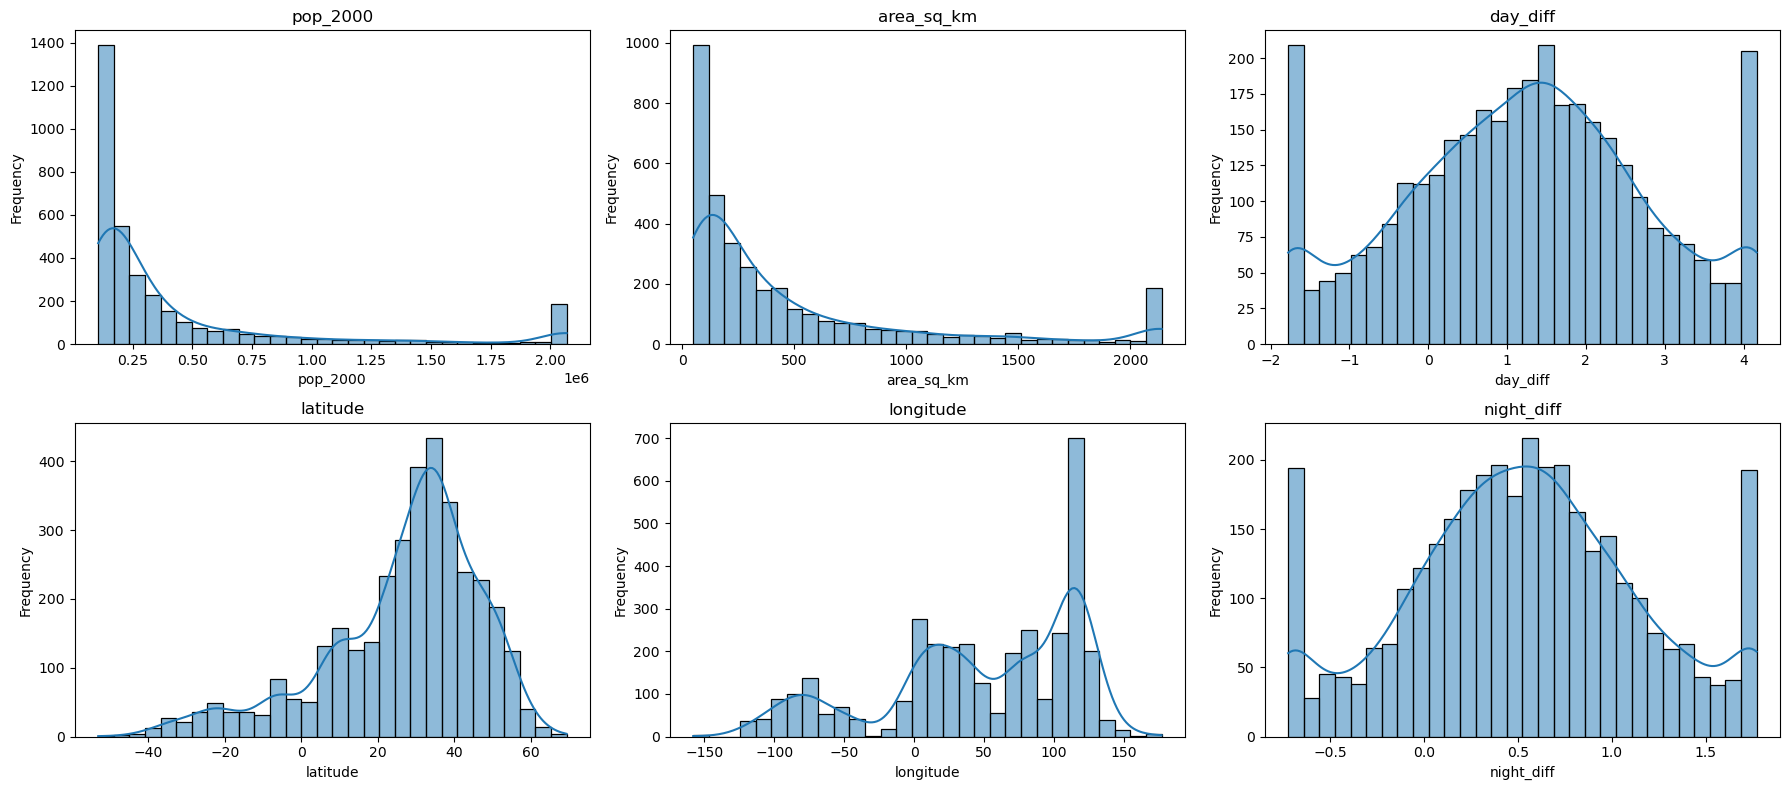

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns to plot
columns = ['pop_2000', 'area_sq_km', 'day_diff', 'latitude', 'longitude', 'night_diff']

# Set up figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Plot histograms
for i, column in enumerate(columns):
    sns.histplot(df[column], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

We see a normal distribution for `day_diff` and `night_diff` as expected, with high frequencies at the low and high ends that result from the winsorization we performed on outliers earlier. Latitude has a left-skewed distribution, reflecting the higher density of cities in the northern hemisphere. Longitude displays three prominent humps, the left one presumably being for North America, the middle for Europe, and the right one for Asia.

### Feature correlations
We will look at the correlations between every pair of features, as well as between the features and the label, `night_diff`.

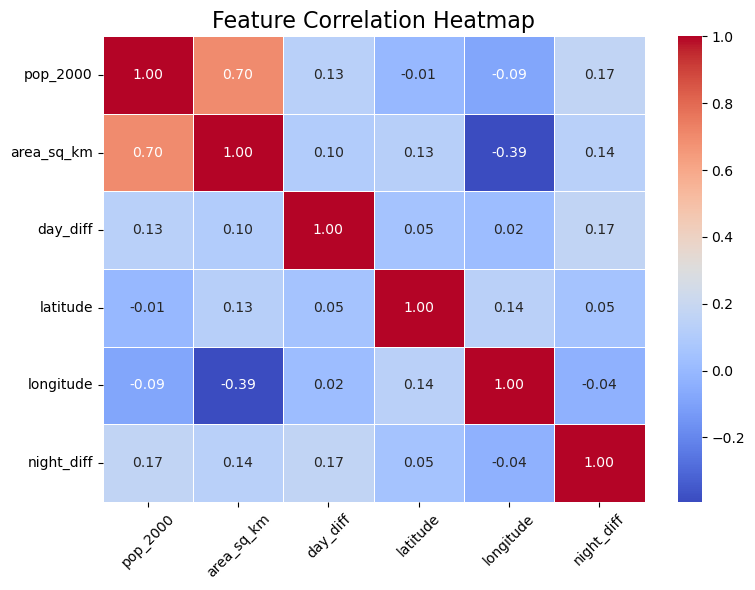

In [19]:
# Select features
features = ['pop_2000', 'area_sq_km', 'day_diff', 'latitude', 'longitude', 'night_diff']

# Compute the correlation matrix
correlation_matrix = df[features].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Display correlation values
    cmap='coolwarm',  # Choose a color palette
    fmt='.2f',  # Format the annotation text
    linewidths=0.5,  # Add lines between cells
    cbar=True  # Show the color bar
)

# Add a title
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Display the plot
plt.tight_layout()
plt.show()

"""
# Create the pairplot
sns.pairplot(df[features], diag_kind='kde', kind='scatter', plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()
""";

We see a moderate linear relationship between the land area of a city and its population, which is sensible. All other feature correlations are fairly weak, which is a good sign because it means multicollinearity will not be a significant issue.

The feature with the highest correlation coefficient with `night_diff` is `day_diff`, which make sense. If a city has a significant temperature difference between its urban core and its surroundings during the day, then this phenomenon is likely to continue into the nighttime as well.

### UHIs by country
Because `night_diff` represents how much cooler the city surface is at night compared to the daytime on average, larger values indicate stronger UHI effects due to the temperature not changing much, which is because manmade surfaces, buildings, vehicles, etc. are holding onto heat effectively at night.

In [20]:
# Find mean nighttime temp. difference by country
mean_nd_by_country = df.groupby("iso3")["night_diff"].mean().to_frame().reset_index()

# Find 5 countries with most and least intense UHI effects respectively
top_5_worst_UHI = mean_nd_by_country.sort_values(by="night_diff", ascending=False).head(5)
top_5_best_UHI = mean_nd_by_country.sort_values(by="night_diff", ascending=True).head(5)

# Display results
print(f"5 most severe \n {top_5_worst_UHI} \n")
print(f"5 least severe \n {top_5_best_UHI}")

5 most severe 
     iso3  night_diff
130  REU    1.770495
9    BDI    1.770495
133  RWA    1.770495
129  QAT    1.751693
5    ARM    1.660881 

5 least severe 
    iso3  night_diff
44  ERI   -0.723543
91  MAC   -0.723543
16  BHS   -0.723543
98  MLT   -0.723543
15  BHR   -0.716481


<b>REWRITE THIS ENTIRE INTERPRETATION TO REFLECT THE LATEST VALUES.</b>

The 5 countries/territories with the strongest average UHI effects are Liechtenstein (LIE), Taiwan (TWN), Kuwait (KWT), Svalbard and Jan Mayen (SJM) (Part of Norway), and The Vatican (VAT). All of these countries/territories are very small and have high population densities, and small countries often have dense urban centers because their limited land area leads to concentrated development. This results in more severe UHI effects because of the lack of natural green spaces to offset urban heat.

The 5 countries/territories with the weakest average UHI effects are Brunei (BRN), Barbados (BRB), Seychelles (SYC), Wallis and Futuna (WLF), and Macao (MAC). All of these places are either islands or small countries situated near a large body of water, and water is highly effective at absorbing heat during the day and releasing it at night, moderating the temperature of nearby land. Countries like Brunei, Barbados and Seychelles also have very high percentages of their land area covered by natural greenery, mitigating UHI effects.

In [21]:
import folium
from matplotlib import cm, colors
import branca.colormap as bcm

# Take subset of dataset
data = df[["name", "pop_2000", "latitude", "longitude", "night_diff"]]

# Cap values at the 95th percentile
threshold = min(np.percentile(data["night_diff"], 95), 12)  # Use 12°C as a max reasonable limit
#data["night_diff"] = np.clip(data["night_diff"], None, threshold)
data.loc[:, "night_diff"] = np.clip(data["night_diff"], None, threshold)

# Normalize night_diff for color mapping
norm = colors.Normalize(vmin=data["night_diff"].min(), vmax=data["night_diff"].max())
colormap = cm.ScalarMappable(norm=norm, cmap="viridis")  # Use a colormap like 'viridis'

# Create a linear colormap for the legend
linear_colormap = bcm.LinearColormap(
    ['blue', 'green', 'orange', 'red'],  # Adjust the colors as needed
    vmin=data["night_diff"].quantile(0.05),
    vmax=data["night_diff"].quantile(0.95),
    caption="Night Diff"
)

# Create a Folium map
m = folium.Map(location=[data["latitude"].mean(), data["longitude"].mean()], zoom_start=2)

# Add individual markers with dynamic color mapping
for _, row in data.iterrows():
    color = colors.rgb2hex(colormap.to_rgba(row["night_diff"]))  # Convert RGBA to hex
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=2,  # Size of the marker
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"{row['name']}: Night Diff {row['night_diff']:.2f}"
    ).add_to(m)

# Add the colormap to the map
linear_colormap.add_to(m)

# Save the map
m.save("UHI_map_dynamic.html")
m

In [22]:
# Show descriptive statistics for night_diff
data["night_diff"].describe().to_frame().transpose()

count      mean       std       min       25%       50%  \
night_diff  3519.0  0.527973  0.626854 -0.723543  0.126282  0.528145   

                 75%       max  
night_diff  0.933551  1.769691

We see larger numbers of cities with high temperature differences in Latin America, the Middle East, Italy, and South Asia. These regions are less wealthy on average than Western Europe and North America, so they're less likely to be able to afford high-quality materials, cool roofs and green spaces that could reduce the amount of heat retained by the city surface. All of these UHI-prone regions also have hot climates and densely-packed cities that exacerbate the problem.

### Spatial Analysis
This will determine whether spatial effects are significant, IE whether cities near each other exhibit similar UHI effects.

In [23]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def mantel_test(df, value_col, lat_col, lon_col, num_permutations=999):
    """
    Performs a Mantel test to assess spatial autocorrelation.

    Args:
        df: Pandas DataFrame containing your data.
        value_col: Name of the column with the values to analyze.
        lat_col: Name of the latitude column.
        lon_col: Name of the longitude column.
        num_permutations: Number of permutations for significance testing.

    Returns:
        A tuple containing the Mantel correlation coefficient and p-value.
    """

    # 1. Create spatial distance matrix
    coords = df[[lon_col, lat_col]].values
    spatial_dist_matrix = distance.cdist(coords, coords, 'euclidean')

    # 2. Create difference matrix
    value_diff_matrix = distance.pdist(df[value_col].values.reshape(-1, 1), 'euclidean')
    value_diff_matrix = distance.squareform(value_diff_matrix)

    # 3. Perform the Mantel test
    observed_r, _ = pearsonr(spatial_dist_matrix.flatten(), value_diff_matrix.flatten())

    # Permutation test for significance
    permuted_r = []
    for _ in range(num_permutations):
        permuted_values = np.random.permutation(df[value_col].values)
        permuted_diff_matrix = distance.pdist(permuted_values.reshape(-1, 1), 'euclidean')
        permuted_diff_matrix = distance.squareform(permuted_diff_matrix)
        r, _ = pearsonr(spatial_dist_matrix.flatten(), permuted_diff_matrix.flatten())
        permuted_r.append(r)

    p_value = np.mean(np.array(permuted_r) >= observed_r)

    return observed_r, p_value

# Example usage (replace with your DataFrame and column names):
# Assuming your DataFrame is named 'df' and has columns 'night_diff', 'latitude', and 'longitude'
# and that your data is already loaded into the dataframe.

# Sample dataframe creation for testing purposes.
data = {'night_diff': np.random.rand(100),
        'latitude': np.random.rand(100),
        'longitude': np.random.rand(100)}

mantel_df = pd.DataFrame(data)

mantel_r, mantel_p = mantel_test(mantel_df, 'night_diff', 'latitude', 'longitude')

print(f"Mantel's r: {mantel_r}")
print(f"p-value: {mantel_p}")

# Optional: Visualize the distance matrices (for small datasets)
if len(mantel_df) <= 20 : # only visualize if the dataframe is small.
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(distance.cdist(df[['longitude', 'latitude']], df[['longitude', 'latitude']], 'euclidean'), cmap='viridis')
    plt.title('Spatial Distance Matrix')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(distance.squareform(distance.pdist(df['night_diff'].values.reshape(-1, 1), 'euclidean')), cmap='viridis')
    plt.title('Value Difference Matrix')
    plt.colorbar()

    plt.show()

Mantel's r: 0.04777806096794069
p-value: 0.18618618618618618


In [24]:
"""
import geopandas as gpd
from pysal.lib import weights
from pysal.explore.esda import Moran
import matplotlib.pyplot as plt

# Create GeoDataFrame
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Define a distance threshold for spatial neighbors
distance_threshold = 50  # Adjust this based on your data and research question

# Create a KNN (k-Nearest Neighbors) weights matrix
knn = weights.KNN.from_dataframe(gdf, k=4) 
knn.transform = 'r'  # Row-standardize the weights matrix

# Calculate Moran's I
moran = Moran(gdf['night_diff'], knn) 
print("Moran's I:", moran.I)
print("p-value:", moran.p_value)

# Visualize spatial autocorrelation
fig, ax = plt.subplots(figsize=(6, 6))
moran.plot(ax=ax) 
plt.title("Moran Scatterplot")
plt.show()
""";

# Modeling the Data
We will evaluate model performance using RMSE (Root Mean Squared Error).

RMSE is ideal for this project because it amplifies larger deviations, giving us a clearer picture of when the model is far off-target.

### Normalizing numeric features

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Select features and label
features = ["pop_2000", "area_sq_km", "day_diff", "latitude", "longitude"]
x = df[features]
y = df["night_diff"]

# Initialize scaler and normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# View normalized data
df.head()

isourbid iso3  urbid         name  pop_2000  area_sq_km  urban_day_mean  \
22    NZL96  NZL     96     HASTINGS  0.004136    0.142776       32.955030   
23   CHL101  CHL    101     VALDIVIA  0.009789    0.063358       28.505000   
37   CHL125  CHL    125       OSORNO  0.011746    0.111329       35.074372   
51   NZL155  NZL    155   WELLINGTON  0.191282    0.338086       28.241586   
61   CHL183  CHL    183  PUERTOMONTT  0.019350    0.059568       29.314183   

    buffer_day_mean  day_diff  urban_night_mean  buffer_night_mean  \
22        32.955030  0.659659         12.152994          12.060181   
23        28.505000  0.531182         11.028824          10.833907   
37        35.074372  0.508137         10.748484          10.296038   
51        28.241586  0.907340         10.748484          10.296038   
61        29.314183  0.693715         10.748484          10.296038   

    night_diff  latitude  longitude  pop_per_sq_km  
22    0.092813  0.111224   1.000000     327.704947  
23    0.194916  0.108677   0.253046     691.164472  
37   -0.071490  0.102779   0.253249     457.733674  
51    0.209028  0.097462   0.994204     636.974662  
61   -0.723543  0.095306   0.253869     831.833315

The final preparation step is to split the data into training and testing sets to evaluate the model's performance.

### Train-test split

In [26]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Show shapes of training and testing sets
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (2815, 5)
Shape of x_test: (704, 5)
Shape of y_train: (2815,)
Shape of y_test: (704,)


Having been cleaned and normalized, the data is now ready for basic regression modeling.

### Model 1: Linear regression model
We will start with a linear regression model to keep things simple.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create and fit LR model
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

Let's see if this model has significant explanatory power by calculating the F-statistic:

In [28]:
# Function to calculate the F-statistic of a model
def calculate_f_statistic():
    
    # Calculate components of F-statistic
    n = x_train.shape[0]  # Number of observations
    p = x_train.shape[1]  # Number of predictors
    tss = np.sum((y_train - np.mean(y_train))**2) # Total sum of squares (TSS)
    sse = np.sum((y_test - y_pred)**2) # Residual sum of squares (SSE)
    ssr = tss - sse # Explained sum of squares (SSR)
    df_model = p # Model degrees of freedom
    df_residual = n - p - 1 # Residual degrees of freedom
    ms_model = ssr / df_model  # Mean square for the model
    ms_residual = sse / df_residual  # Mean square for residuals

    # Calculate F-statistic
    f_statistic = ms_model / ms_residual
    print(f"F-statistic: {f_statistic}")
    
# Find F-statistic for linear regression model
calculate_f_statistic()

F-statistic: 1728.7774008414572


In [29]:
# Calculate and display RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}") 

# Calculate and display R^2 and adjusted R^2
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}") 
n = len(y_test)
p = x_test.shape[1]
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Adjusted R²: {adj_r2}")

# Find and display model coefficients
intercept = model.intercept_
coefficients = model.coef_
feature_names = x_train.columns
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print("\n", coef_df)

RMSE: 0.6189256279143645
MAE: 0.4935912320962019
R²: 0.04403605470372529
Adjusted R²: 0.03718817543942521

       Feature   Coefficient
0    pop_2000  2.021305e-07
1  area_sq_km -1.364684e-05
2    day_diff  5.769805e-02
3    latitude  1.825073e-03
4   longitude -2.175161e-04


In line with what we found earlier, a city's land area and the daytime temperature difference between the urban core and surroundings are the most impactful factors on the nighttime temperature difference by far.

(REWRITE) Also, our RMSE indicates that on average, the model's nighttime prediction is off by 1.2 degrees Celsius. Let's look at the actual `night_diff` values to contextualize this value.

In [30]:
# Show nighttime temperature stats
df["night_diff"].describe().to_frame().transpose()

count      mean       std       min       25%       50%  \
night_diff  3519.0  0.528013  0.626934 -0.723543  0.126282  0.528145   

                 75%       max  
night_diff  0.933551  1.770495

(REWRITE) The mean is only about 0.2°C, so the model's accuracy is questionable at best. This will require some further examination later.

This F-statistic is extremely high and indicates that the model's predictor variables are strongly correlated with the label.

In [31]:
# Get DescStats for night temperature difference
df["night_diff"].describe()

count    3519.000000
mean        0.528013
std         0.626934
min        -0.723543
25%         0.126282
50%         0.528145
75%         0.933551
max         1.770495
Name: night_diff, dtype: float64

Let's create a residual plot to see if any systemic patterns show up. If so, it might indicate that the model is not capturing the relationships properly.

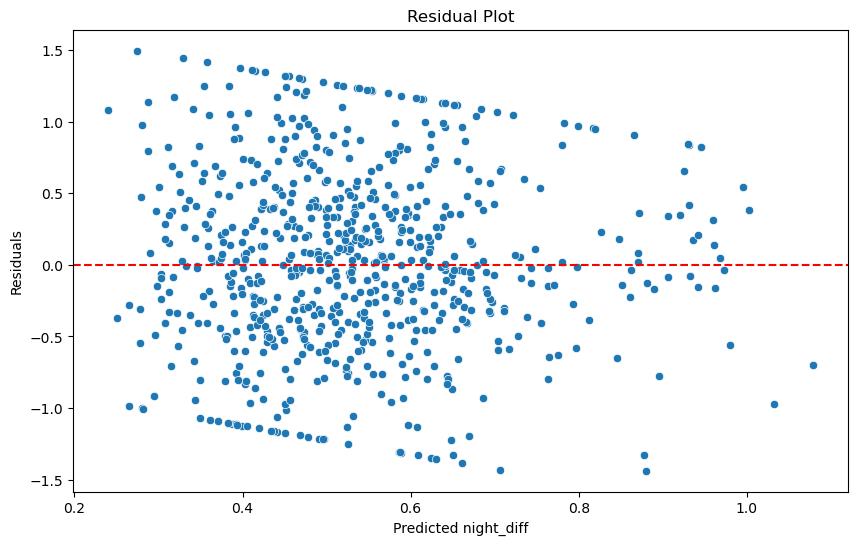

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted night_diff")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

We see a downward trend among the residuals as predictions get larger, especially at the top and bottom of the spread, which are presumably the outliers that were capped at the 5th and 95th percentiles earlier. This indicates that the model tends to underpredict at larger label values.

### Model 2: Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Calculate F-statistic
calculate_f_statistic()

F-statistic: 1728.7774008414572


In [34]:
# Make predictions and evaluate the model
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

Random Forest RMSE: 0.6053580132390087


We see basically no improvement in RMSE from the linear regression model from the random forest. Thus, we will try an ensemble of multiple models and evaluate its performance.

### Model 3: Ensemble Regressor
Our initial ensemble will include a linear regression model, a random forest, an XGBoost algorithm, and a ridge regression model.

In [35]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Define models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
ridge_model = Ridge(alpha=1.0)

# Train models
lr_model.fit(x_train, y_train)
rf_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)
ridge_model.fit(x_train, y_train);

# Create and fit ensemble model
model = VotingRegressor(estimators=[
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('ridge', ridge_model)
])
model.fit(x_train, y_train);

# Calculate F-statistic
calculate_f_statistic()

F-statistic: 1832.6033542517623


In [36]:
# Make predictions and evaluate the model
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Ensemble RMSE: {rmse}")

Ensemble RMSE: 0.6004855121224733


The ensemble barely shows any improvement over the linear regression model or random forest, suggesting that the problem may lie with data quality. If even an ensemble cannot get RMSE below a reasonable level, then the model cannot be the problem.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3519 entries, 22 to 31434
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isourbid           3519 non-null   object 
 1   iso3               3519 non-null   object 
 2   urbid              3519 non-null   int64  
 3   name               3519 non-null   object 
 4   pop_2000           3519 non-null   float64
 5   area_sq_km         3519 non-null   float64
 6   urban_day_mean     3519 non-null   float64
 7   buffer_day_mean    3519 non-null   float64
 8   day_diff           3519 non-null   float64
 9   urban_night_mean   3519 non-null   float64
 10  buffer_night_mean  3519 non-null   float64
 11  night_diff         3519 non-null   float64
 12  latitude           3519 non-null   float64
 13  longitude          3519 non-null   float64
 14  pop_per_sq_km      3519 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 439.9+ KB
